In [1]:
import math
import numpy as np
import pandas as pd
import os
import seaborn as sns

pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
# change font
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

import warnings
warnings.filterwarnings('ignore')

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 0. Read Data

Fetal Health Classification Dataset: https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification

Original article: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6822315/

In [3]:
df_input = pd.read_csv(os.path.join(os.getcwd(), '..', 'data', 'fetal_health.csv'))
df_input.columns = [col.replace('_', ' ') for col in df_input.columns]
df_input

,baseline value,accelerations,fetal movement,uterine contractions,light decelerations,severe decelerations,prolongued decelerations,abnormal short term variability,mean value of short term variability,percentage of time with abnormal long term variability,mean value of long term variability,histogram width,histogram min,histogram max,histogram number of peaks,histogram number of zeroes,histogram mode,histogram mean,histogram median,histogram variance,histogram tendency,fetal health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,40.0,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,66.0,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,67.0,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


In [4]:
df_input.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal short term variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean value of short term variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage of time with abnormal long term variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


Fetal health (target column):
- 1 - Normal
- 2 - Suspect
- 3 - Pathological

For this notebook, we will consider only the Normal/not Normal distinction (binary classification)

In [5]:
df_input['fetal health'].value_counts()

1.0    1655
2.0     295
3.0     176
Name: fetal health, dtype: int64

In [6]:
df_input['fetal health binary'] = (df_input['fetal health'] == 1).astype(int)

In [7]:
df_input['fetal health binary'].value_counts()

1    1655
0     471
Name: fetal health binary, dtype: int64

In [8]:
classes_dict = {
    0:'Not Normal',
    1:'Normal'
}

In [9]:
X = df_input[[col for col in df_input.columns if col not in ['fetal health', 'fetal health binary']]]
y = df_input['fetal health binary']

## 1. EDA

Illustrative EDA example

<Figure size 1728x1728 with 0 Axes>

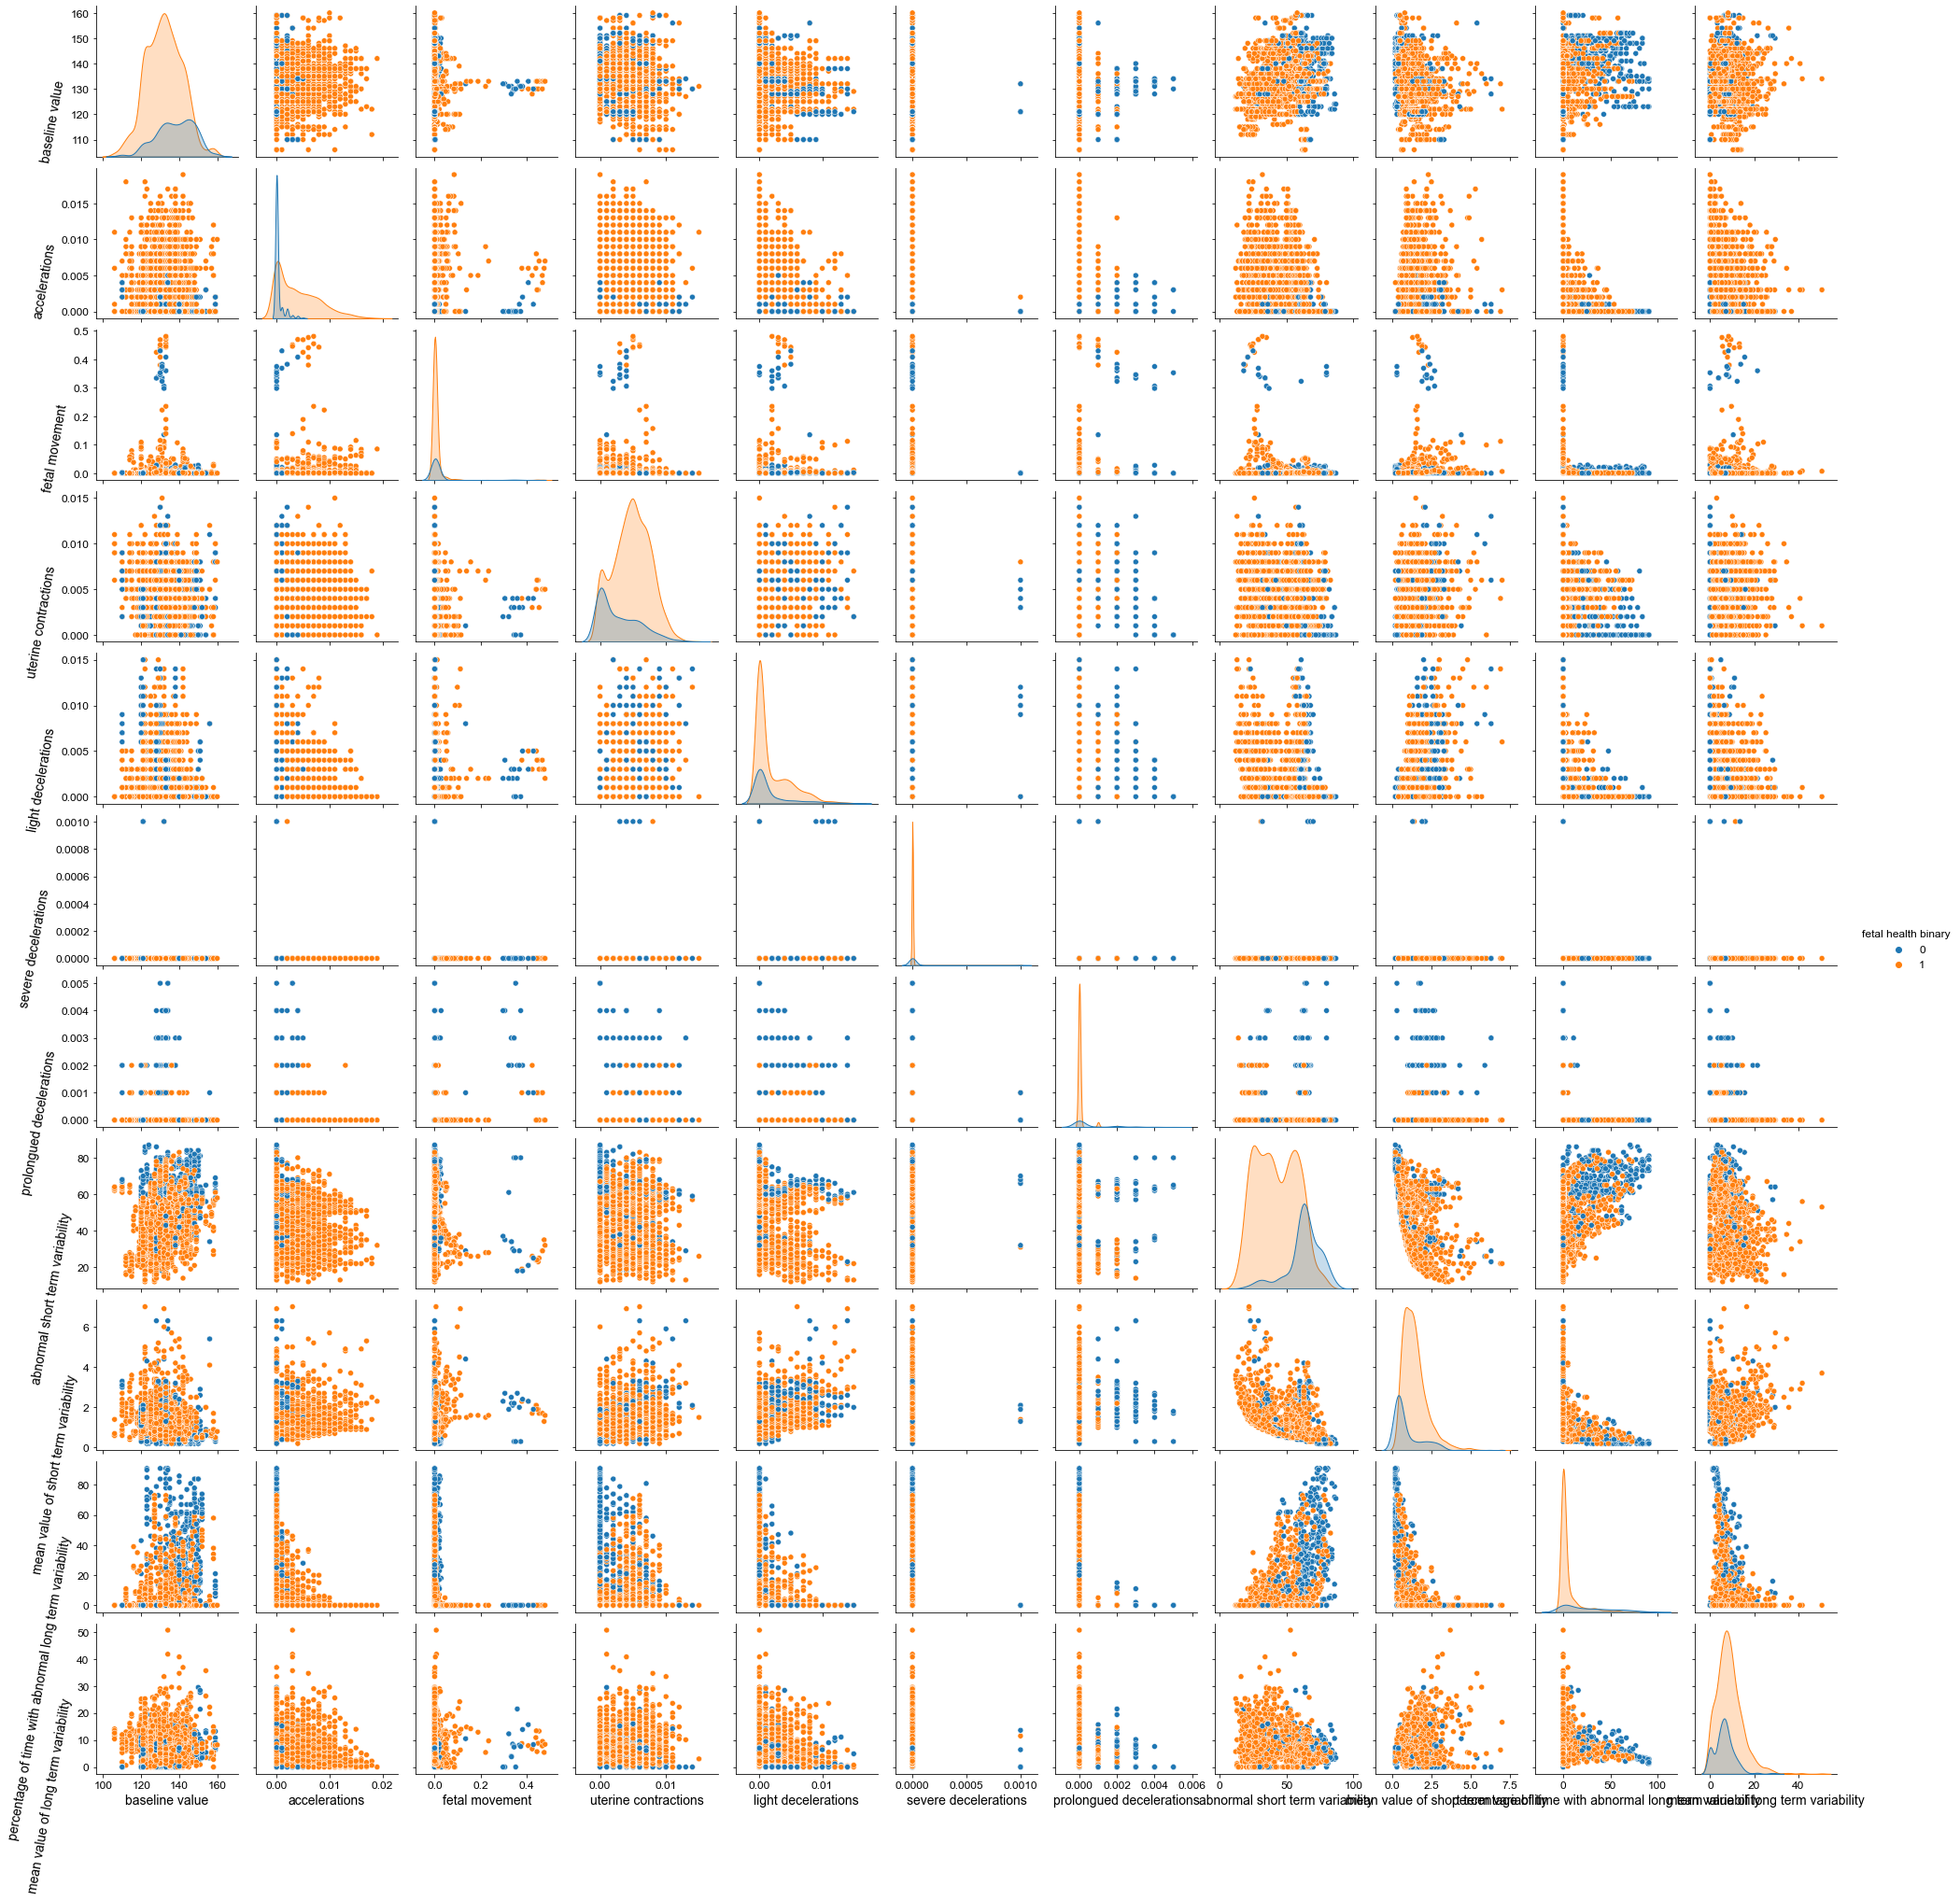

In [10]:
plt.figure(figsize=(24, 24))

plot_cols = [col for col in X.columns if not col.startswith('histogram')]
pairplot = sns.pairplot(pd.concat([X[plot_cols], y], axis=1), hue='fetal health binary')
# rotate y labels
for ax in pairplot.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation=0)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation=80)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

plt.show()

In [11]:
def plot_boxplots(X, y, features_to_plot):
    
    PLOTS_PER_ROW = 4
    with sns.axes_style("darkgrid"):
        fig, axes = plt.subplots(math.ceil(len(features_to_plot)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(22, 4*math.ceil(len(features_to_plot)/3)))
    fig.subplots_adjust(hspace=.3, wspace=.2)
    
    i, j = 0, 0
    for feature in features_to_plot:
        sns.boxplot(
            x=y.apply(lambda cell: classes_dict[cell]), y=X[feature], order=classes_dict.values(), ax=axes[i][j], palette="YlGnBu",
            medianprops=dict(linewidth=4, color="blue", alpha=1.0), flierprops=dict(markerfacecolor="#707070", marker="d"),
            showmeans=True, meanprops={"marker":"X","markerfacecolor":"limegreen", "markeredgecolor":"green" ,"markersize":10}
        )
        axes[i][j].set_title(feature, fontsize=MEDIUM_SIZE)
        axes[i][j].set_ylabel('', fontsize=SMALL_SIZE)
        axes[i][j].set_xlabel('', fontsize=SMALL_SIZE)

        j += 1
        if j % PLOTS_PER_ROW == 0:
            i += 1
            j = 0
            
    plt.show()

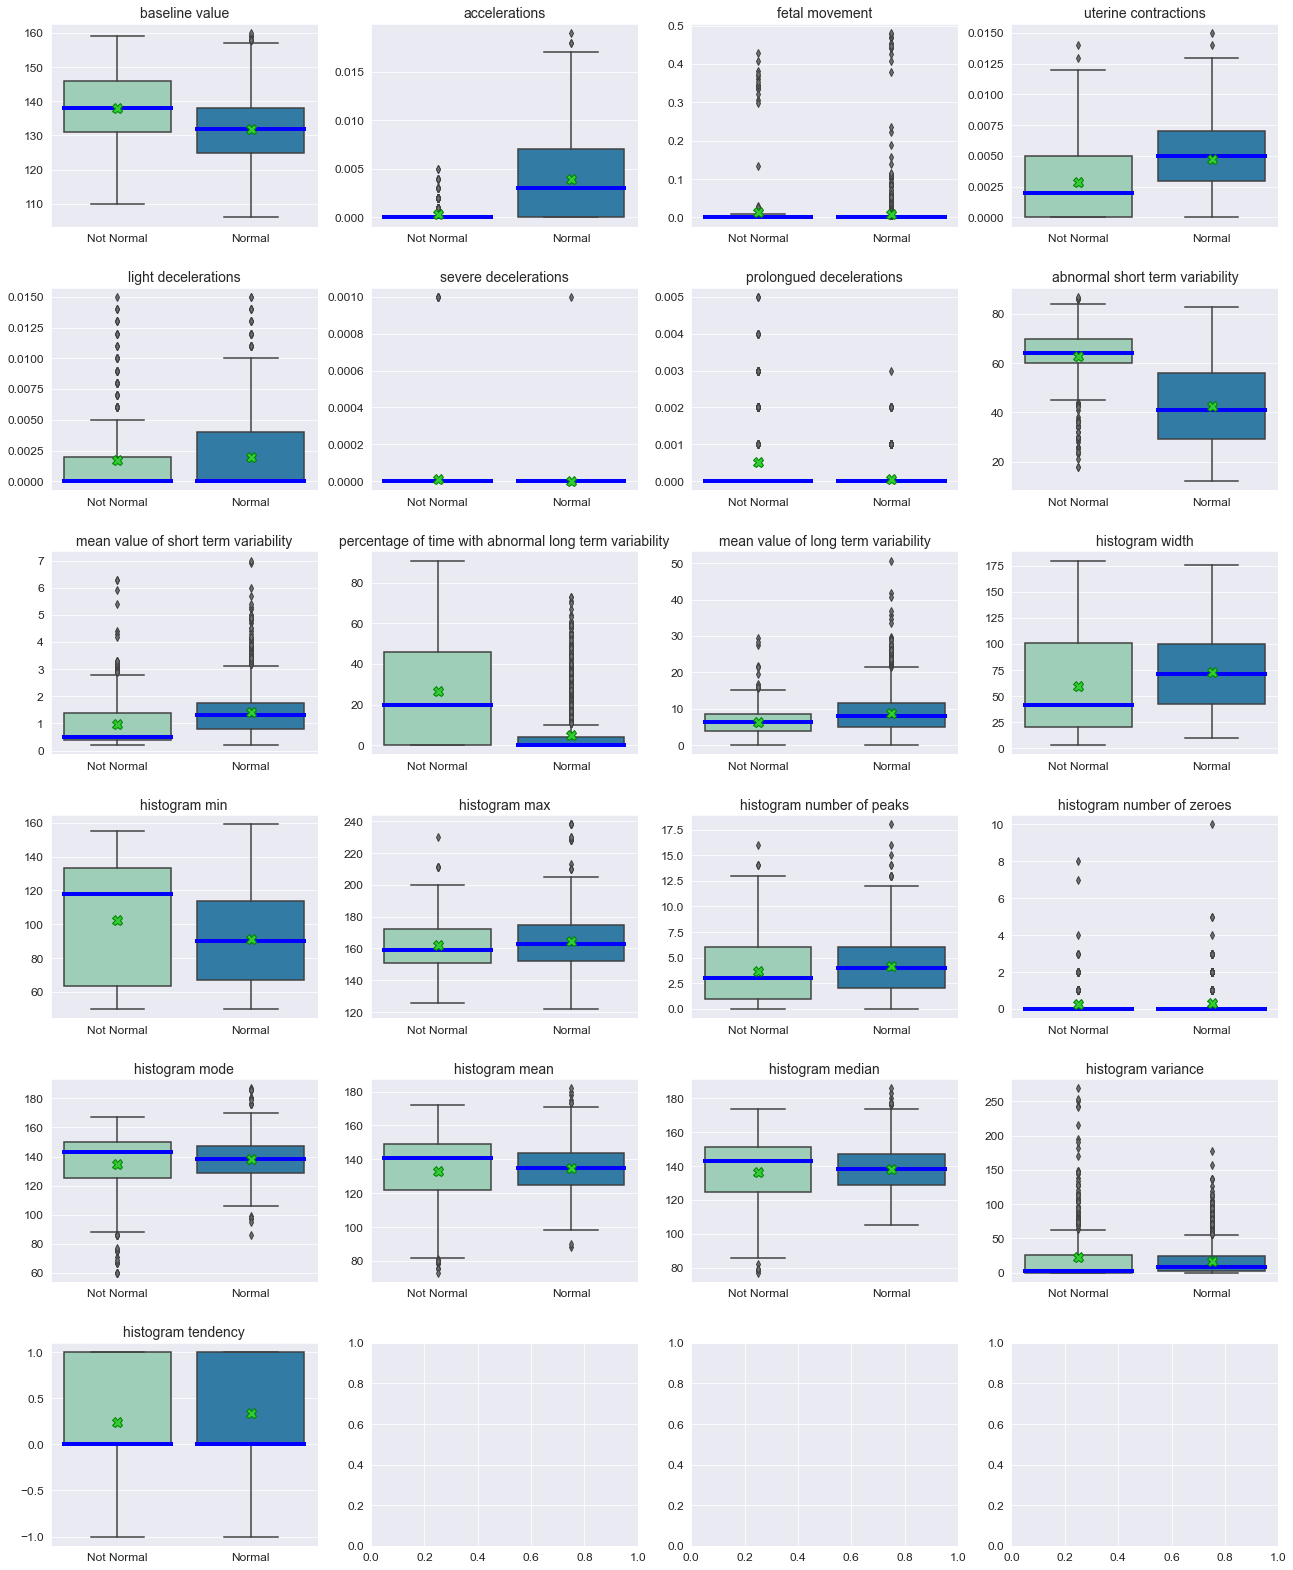

In [12]:
plot_boxplots(X, y, X.columns)

## 2. Correlation Analysis

### 2.1. Pearson's Correlation Coefficient

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
# Compute features' correlation
X_corr = X.corr()

# Generate a mask to onlyshow the bottom triangle
mask_corr = np.triu(np.ones_like(X_corr, dtype=bool))

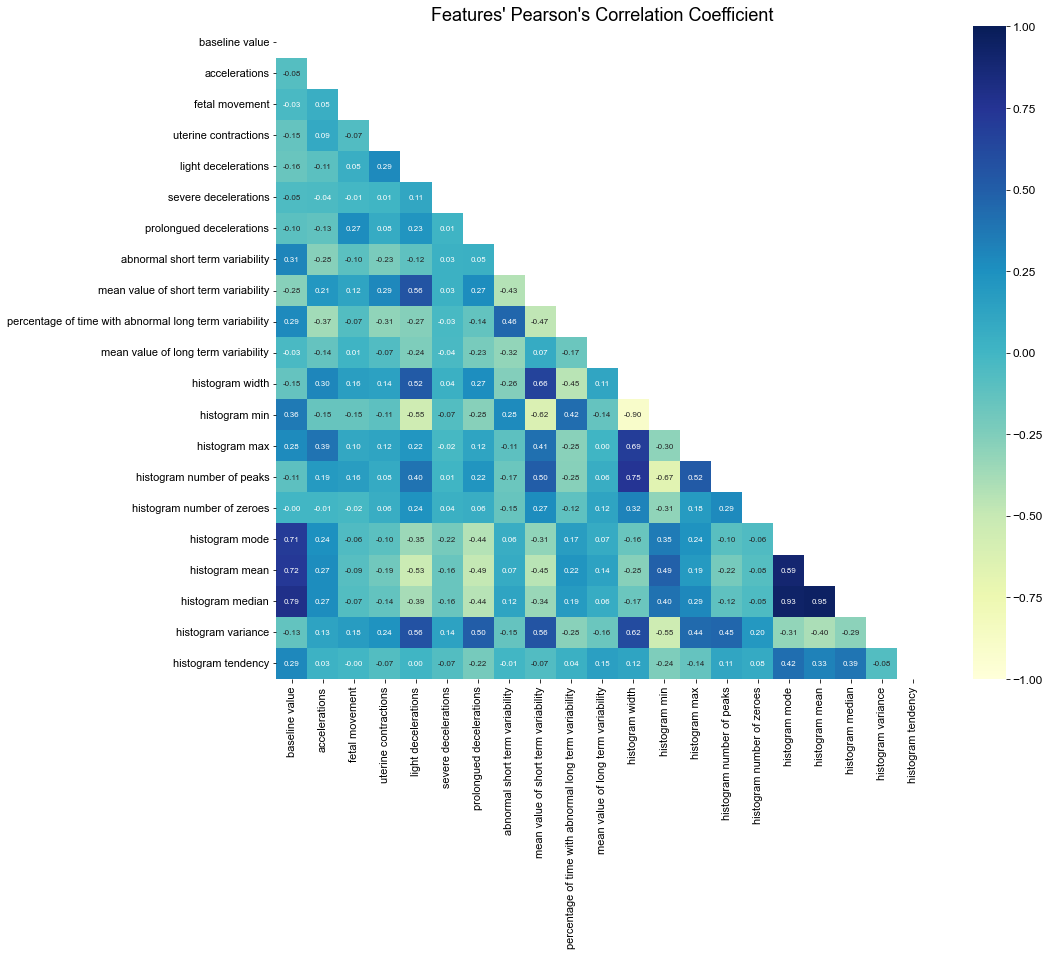

In [15]:
plt.figure(figsize=(16,12))
plt.title("Features' Pearson's Correlation Coefficient", fontsize=18)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# generate heatmap
sns.heatmap(X_corr, cmap='YlGnBu', annot=True, mask=mask_corr, vmin=-1, vmax=1, square=True, annot_kws={'fontsize':8}, fmt='.2f')

plt.show()

Most features do not appear to have strong positive or negative correlations with other features, but there are cases where correlation is high

### 2.2. Multicollinearity

> Multicollinearity is a problem because it undermines the statistical significance of an independent variable. [\[source\]](https://link.springer.com/chapter/10.1007/978-0-585-25657-3_37)

> Multicollinearity does not affect the accuracy of predictive models, including regression models. \[...\] Now, where multicollinearity becomes 'an issue' is when you want to 'interpret' the parameters learned by your model. In other words, you cannot say that the feature with the 'biggest weight' is 'the most important' when the features are correlated. Note that this is independent on the accuracy of the model, this is only the interpretation part [\[source\]](https://www.researchgate.net/post/Are-Random-Forests-affected-by-multi-collinearity-between-features)

> Multicollinearity is only a problem for inference in statistics and analysis. For example, if you’d like to infer the importance of certain features, then almost by definition multicollinearity means that some features are shown as strongly/perfectly correlated with other combination of features, and therefore they are undistinguishable. In this case, you can simply remove the problematic features.
Multicollinearity is not a real problem for prediction. GBT, being more of a black-box model, is more suitable for predictions problems to start with, although of course you could try and use them for inference as well.
[\[source\]](https://www.quora.com/Is-multicollinearity-a-problem-with-gradient-boosted-trees)



#### 2.2.1. Variance Inflation Factor (VIF)

Here’s the formula for calculating the VIF for feature X1: $VIF_{1}=\frac{1}{1-R_{1}^{2}}$

$R^2$ in this formula is the coefficient of determination from the linear regression model which has: X1 as dependent variable (target), and X2, X3, ... as independent variables (features). To calculate VIF for each features, you have to fit a linear regression using such feature as the target.

As a general rule of thumb, "VIF > 5 is cause for concern and VIF > 10 indicates a serious collinearity problem."

- If feature X1 has VIF = 1 (minimum possible value for VIF), then there is zero collinearity between this feature and the other features in the dataset (e.g. X2, X3, ...)
- If feature X1 has VIF = 2.5, then the variance of the regression coefficient of X1 in the original linear regression model is 2.5 times greater than it would have been if X1 had been entirely non-related to other features
- If feature X1 has VIF = Inf, then X1 can be perfectly predicted by using the other features in the dataset
[\[source\]](https://quantifyinghealth.com/vif-threshold/#:~:text=Most%20research%20papers%20consider%20a,of%205%20or%20even%202.5.)

The higher the VIF:
- The more correlated a predictor is with the other predictors
- The more the standard error is inflated
- The larger the confidence interval
- The less likely it is that a coefficient will be evaluated as statistically significant
[\[source\]](https://towardsdatascience.com/everything-you-need-to-know-about-multicollinearity-2f21f082d6dc)

For implementation example with evaluation on performance and feature importance, read [\[this article\]](https://towardsdatascience.com/targeting-multicollinearity-with-python-3bd3b4088d0b)

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [17]:
df_vif = pd.DataFrame(X.columns, columns=['feature'])
df_vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
df_vif = df_vif.sort_values('VIF', ascending=False).set_index('feature', drop=True)
df_vif

,VIF
feature,
histogram width,inf
histogram max,inf
histogram min,inf
histogram median,2429.742819
histogram mean,1503.040984
baseline value,1058.823853
histogram mode,643.767283
abnormal short term variability,16.051631
mean value of short term variability,9.457023


**Which features would remain if we removed all features with VIF > 10?**

In [18]:
def check_vif(X, threshhold=10):
    features = list(X.columns)
    max_len = max([len(f) for f in features])
    high_vif_cols = []

    for i in range(len(features)):
        vif = [variance_inflation_factor(X[features].values, ix) for ix in range(X[features].shape[1])]
        max_idx = np.argmax(vif)
        if max(vif) > threshhold:
            high_vif_col = features.pop(max_idx)
            high_vif_cols.append(high_vif_col)
            print(f'{i+1}. Removed feature: {(high_vif_col+" ").ljust(max_len+2,".")} VIF: {vif[max_idx]:.2f}')
            
    print(f'\nRemaining features:\n{features}')
    
    df_vif_final = pd.DataFrame(features, columns=['feature'])
    df_vif_final['VIF'] = [variance_inflation_factor(X[features].values, i) for i in range(len(features))]
    df_vif_final = df_vif_final.sort_values('VIF', ascending=False).set_index('feature', drop=True)
    df_vif_final
    
    return high_vif_cols, df_vif_final

In [19]:
high_vif_cols, df_vif_final = check_vif(X)

1. Removed feature: histogram width ........................................ VIF: inf
2. Removed feature: histogram median ....................................... VIF: 2429.74
3. Removed feature: histogram mean ......................................... VIF: 1150.25
4. Removed feature: baseline value ......................................... VIF: 576.70
5. Removed feature: histogram mode ......................................... VIF: 229.32
6. Removed feature: histogram max .......................................... VIF: 93.14
7. Removed feature: histogram min .......................................... VIF: 13.23

Remaining features:
['accelerations', 'fetal movement', 'uterine contractions', 'light decelerations', 'severe decelerations', 'prolongued decelerations', 'abnormal short term variability', 'mean value of short term variability', 'percentage of time with abnormal long term variability', 'mean value of long term variability', 'histogram number of peaks', 'histogram number of ze

In [20]:
df_vif_final

,VIF
feature,
mean value of short term variability,7.479610
abnormal short term variability,5.700483
histogram number of peaks,4.726697
mean value of long term variability,3.821014
light decelerations,3.558557
uterine contractions,3.369080
histogram variance,3.242490
accelerations,2.570594
percentage of time with abnormal long term variability,2.139653


__________

#### 2.2.2. Principal Component Analysis (PCA)

Principal Components Analysis (PCA) is a well-known unsupervised dimensionality reduction technique that constructs relevant features/variables through linear (linear PCA) or non-linear (kernel PCA) combinations of the original variables (features).

The construction of relevant features is achieved by linearly transforming correlated variables into a smaller number of uncorrelated variables. This is done by projecting (dot product) the original data into the reduced PCA space using the eigenvectors of the covariance/correlation matrix aka the principal components (PCs).

The resulting projected data are essentially linear combinations of the original data capturing most of the variance in the data.

[\[source\]](https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e)

Additional insighful article on multicollinearity and model interpretability: [\[source\]](https://marinawyss.github.io/multicollinearity/)

In [21]:
from sklearn.decomposition import PCA

In [22]:
# Standardize X
stdscaler_initial = StandardScaler()
X_standardized = pd.DataFrame(stdscaler_initial.fit_transform(X), columns=X.columns)

In [23]:
# use all possible PC's
pca_initial = PCA(n_components=X_standardized.shape[1])

pca_cols = [f'PC{i}' for i in range(1,X_standardized.shape[1]+1)]
# The PCA model requires standardized (z-scored) data
X_pca = pd.DataFrame(pca_initial.fit_transform(X_standardized), columns=pca_cols)

In [24]:
df_vif_pca = pd.DataFrame(pca_cols, columns=['PC'])
df_vif_pca['VIF'] = [variance_inflation_factor(X_pca, i) for i in range(X_pca.shape[1])]
df_vif_pca

,PC,VIF
0,PC1,1.0
1,PC2,1.0
2,PC3,1.0
3,PC4,1.0
4,PC5,1.0
5,PC6,1.0
6,PC7,1.0
7,PC8,1.0
8,PC9,1.0
9,PC10,1.0


In [25]:
df_vif_pca['VIF'].round(decimals=1).value_counts()

1.0    21
Name: VIF, dtype: int64

With PCA, we removed all the multicolinearity in the data

In [26]:
# Compute features' correlation
X_corr_pca = X_pca.corr()

# Generate a mask to onlyshow the bottom triangle
mask_corr_pca = np.triu(np.ones_like(X_corr_pca, dtype=bool))

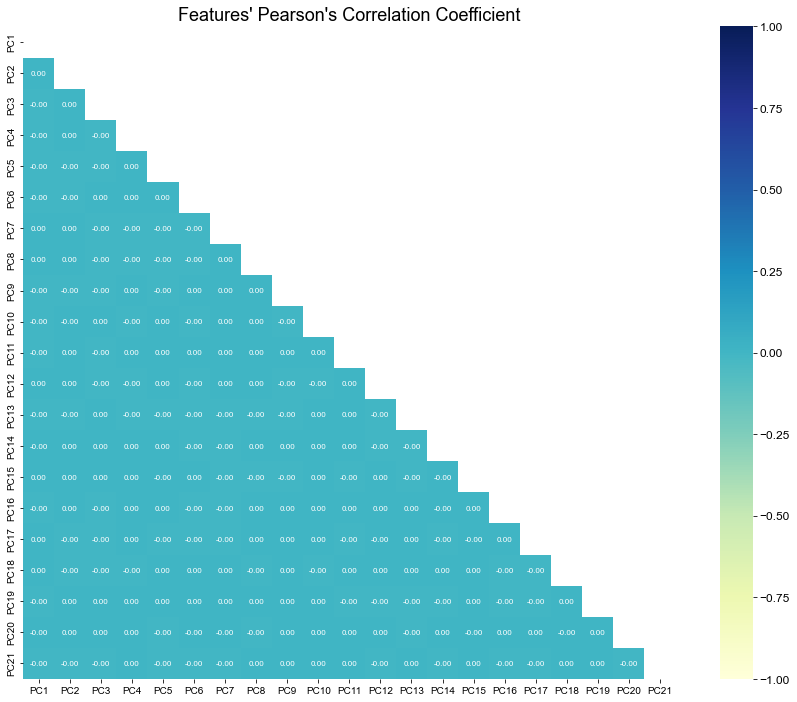

In [27]:
plt.figure(figsize=(16,12))
plt.title("Features' Pearson's Correlation Coefficient", fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# generate heatmap
sns.heatmap(X_corr_pca, cmap='YlGnBu', annot=True, mask=mask_corr_pca, vmin=-1, vmax=1, square=True, annot_kws={'fontsize':8}, fmt='.2f')

plt.show()

#### 2.2.3. PCA after train test split

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, df_input.index, test_size=0.2, random_state=0)

In [30]:
y_train.value_counts()

1    1329
0     371
Name: fetal health binary, dtype: int64

In [31]:
# Standardize X_train
stdscaler = StandardScaler()
X_train_std_allcols = pd.DataFrame(stdscaler.fit_transform(X_train), columns=X.columns, index=idx_train)
X_test_std_allcols = pd.DataFrame(stdscaler.transform(X_test), columns=X.columns, index=idx_test)

In [32]:
# A) Select components that explain 90% of the variability in the original data
n_components = np.argmax(pca_initial.explained_variance_ratio_.cumsum() > 0.98) + 1
# B) use all PC's
# n_components = X.shape[1]

# use selected PC's
pca = PCA(n_components=n_components)

pca_cols = [f'PC{i}' for i in range(1,n_components+1)]
# The PCA model requires standardized (z-scored) data
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_std_allcols), columns=pca_cols, index=idx_train)
X_test_pca = pd.DataFrame(pca.transform(X_test_std_allcols), columns=pca_cols, index=idx_test)
X_train_pca_coeffs = pd.DataFrame(pca.components_, index=pca_cols, columns=X.columns)

print(f"Number of Principal Components (PC's) used: {len(pca.explained_variance_ratio_)} (out of {X.shape[1]} possible PC's)")
print(f"Those {len(pca.explained_variance_ratio_)} PC's explain {pca.explained_variance_ratio_.sum()*100:.1f}% of the variance in the original data")

Number of Principal Components (PC's) used: 16 (out of 21 possible PC's)
Those 16 PC's explain 98.4% of the variance in the original data


## Auxiliar Functions' Definitions

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [34]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(7, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=BIGGER_SIZE, pad=20)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, ['\n'.join(name.rsplit(' ')) for name in target_names], rotation=0, fontsize=MEDIUM_SIZE)
        plt.yticks(tick_marks, ['\n'.join(name.rsplit(' ')) for name in target_names], fontsize=MEDIUM_SIZE)
    
    cm_copy = cm.copy()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm_copy.max() / 1.5 if normalize else cm_copy.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.1f}%\n({})".format(cm[i, j]*100, cm_copy[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm_copy[i, j] > thresh else "black",
                     fontsize=MEDIUM_SIZE)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm_copy[i, j] > thresh else "black",
                     fontsize=MEDIUM_SIZE)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=MEDIUM_SIZE, labelpad=10)
    plt.xlabel('Predicted label\n\naccuracy={:.2f}%; misclassification={:.2f}%'.format(100*accuracy, 100*misclass), fontsize=MEDIUM_SIZE, labelpad=15)
    plt.show()

In [35]:
def gridsearch_cv(X_train_, y_train_, model, space, n_splits, n_repeats,
                  scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'], refit='f1', random_state=0):
    # ignore warnings via env var because GridSearchCV with n_jobs=-1 triggers parallel backend warnings
    os.environ['PYTHONWARNINGS'] = 'ignore'
    # define evaluation
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    # define search
    search = GridSearchCV(model, space, scoring=scoring, n_jobs=-1, cv=cv, refit=refit, verbose=0)
    # execute search
    result_cv = search.fit(X_train_, y_train_)
    
    return result_cv

In [38]:
def print_metrics_cv(result_cv):
    print('Grid Search CV Best Model - Scoring Metrics:\n')
    print(f"ROC AUC:   {result_cv.cv_results_['mean_test_roc_auc'][result_cv.best_index_]:.3f}")
    print(f"Accuracy:  {result_cv.cv_results_['mean_test_accuracy'][result_cv.best_index_]:.3f}")
    print(f"Precision: {result_cv.cv_results_['mean_test_precision'][result_cv.best_index_]:.3f}")
    print(f"Recall:    {result_cv.cv_results_['mean_test_recall'][result_cv.best_index_]:.3f}")
    print(f"F1 score:  {result_cv.cv_results_['mean_test_f1'][result_cv.best_index_]:.3f}\n")

    print(f'\nBest Hyperparameters: {result_cv.best_params_}\n\n')

In [39]:
def print_metrics(y_test_, y_pred_):
    print('Final Model - Scoring Metrics on Test Dataset:\n')
    print(f"ROC AUC:   {roc_auc_score(y_test_, y_pred_):.3f}")
    print(f"Accuracy:  {accuracy_score(y_test_, y_pred_):.3f}")
    print(f"Precision: {precision_score(y_test_, y_pred_):.3f}")
    print(f"Recall:    {recall_score(y_test_, y_pred_):.3f}")
    print(f"F1 score:  {f1_score(y_test_, y_pred_):.3f}\n\n")
    print('Classification Report: \n')
    print(classification_report(y_test_, y_pred_))

Function to calculate p-values for scikit learn Logistic Regression model.

Source: https://stackoverflow.com/a/47079198

In [36]:
# Source: https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance/47079198#47079198
from scipy.stats import norm

def logit_stderror(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se
    p = (1 - norm.cdf(abs(t))) * 2
    
    return se

In [37]:
import matplotlib.patches as mpatches

def get_order_of_magnitude(number):
    return math.floor(math.log(number, 10))

def plot_importance(df_importance, model_description):

    idx_order = df_importance.index
    df_importance['Absolute Coefficients'] = df_importance['Coefficients'].abs()
    df_importance = df_importance.sort_values('Absolute Coefficients', ascending=True)

    colors_dict = {
        'Positive': 'royalblue',
        'Negative': 'firebrick'
    }
    df_importance['Color'] = df_importance.apply(
        lambda row: colors_dict['Negative'] if row['Coefficients'] < 0 else colors_dict['Positive'], axis=1
    )
    
    fig, ax = plt.subplots()
    
    max_coeff = df_importance['Absolute Coefficients'].max()
    big_cis = []
    cis = df_importance['Standard Error'].copy() * 1.96 # x1.96 to get 95% CI
    for idx, ci in cis.iteritems():
        if get_order_of_magnitude(ci) > get_order_of_magnitude(max_coeff):
            big_cis.append((idx, ci))
            cis.loc[idx] = 0 # remover CIs grandes para que a barra de erro fique dentro da escala visivel
    
    fill_value = 1.75 * np.average([max_coeff, cis.max()]) # valor arbitrario para usar no lugar dos CIs muito grandes
    for idx_err, big_ci in big_cis:
        cis.loc[idx_err] = fill_value # preencher CIs grandes com o maior CI da mesma ordem de grandez (valor arbitrario) 
            
    df_importance['Absolute Coefficients'].plot(
        kind="barh", color=df_importance['Color'], figsize=(10, max(df_importance.shape[0]/2, 7)), legend=False, ax=ax, 
        xerr=cis.reindex(df_importance.index), ecolor='black', error_kw={'label':'95% confidence interval', 'capsize':4, 'capthick':1}
    )
    
    for idx_err, big_ci in big_cis:
        display_string = f". . . .\n(95% CI = ±{big_ci:,.2f})"
        ax.text(df_importance['Absolute Coefficients'].loc[idx_err] + 1.14*fill_value, df_importance['Standard Error'].index.get_loc(idx_err)+0.275,
                display_string, color='black', fontweight='bold', ha='right', va='top', linespacing=1.5)
    
    ax.xaxis.grid()
    ax.set_axisbelow(True)
    plt.title(model_description + ' - Coefficient Values with 95% CI (±1.96 Std Error)', pad=50, fontsize=BIGGER_SIZE)
    legend_patches = [
        ax.get_legend_handles_labels()[0][0], # confidence interval
        mpatches.Patch(color=colors_dict['Positive'], label='Positive Coefficient'),
        mpatches.Patch(color=colors_dict['Negative'], label='Negative Coefficient'),
    ]
    plt.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.125),
                  ncol=3, fancybox=True, shadow=False)
    
    plt.show()
    
    return df_importance[['Coefficients', 'Absolute Coefficients', 'Standard Error']].reindex(idx_order)

In [41]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def check_pca_transform(X_test_std_allcols, y_pred_pca, df_importance_pca, intercept, classes_dict):
    y_pred_proba_pca_reversed = sigmoid(X_test_std_allcols.dot(df_importance_pca['Coefficients']) + intercept)
    y_pred_pca_reversed = (y_pred_proba_pca_reversed > 0.5).astype(int).values
    if (y_pred_pca == y_pred_pca_reversed).astype(int).sum() == X_test_std_allcols.shape[0]:
        print('SUCCESS: PCA coefficients reverse transformation was performed correctly!')
    else:
        print('FAIL: PCA coefficients reverse transformation was NOT performed correctly!')

In [40]:
def plot_eval_metrics_xgb(eval_results, eval_metrics):
    n_epochs = len(eval_results['validation_0'][list(eval_metrics.keys())[0]])

    fig, axes = plt.subplots(nrows=1, ncols=len(eval_metrics.keys()), figsize=(7*len(eval_metrics.keys()),5))
    for ax, (metric_code, metric) in zip(axes, eval_metrics.items()):
        ax.plot(range(n_epochs), eval_results['validation_0'][metric_code], label='Train')
        ax.plot(range(n_epochs), eval_results['validation_1'][metric_code], label='Test')
        ax.set_title(metric, fontsize=MEDIUM_SIZE)
        ax.set_xlabel('Iterations')
        ax.legend()
    plt.suptitle('Evaluation Metrics during Model Training', y=1.05)
    plt.show()

In [42]:
def plot_shap_importance(shap_values, X_test_, classes_dict, model_classes, title='Feature Importance'):
    with sns.axes_style("whitegrid"):
        plt.title(title, fontsize=BIGGER_SIZE)
        shap.summary_plot(shap_values, X_test_, plot_type="bar", class_names=[classes_dict[i] for i in model_classes],
                      max_display=X_test_.shape[1], plot_size=(12,X_test_.shape[1]/2.5))
    plt.show()

In [43]:
def plot_gain_metric_xgb(df_importance_gain, title):
    df_importance_gain.sort_values('Feature Gain', ascending=True).plot(kind="barh", figsize=(12, df_importance_gain.shape[0]/2.5), legend=False)
    plt.gca().xaxis.grid(True)
    plt.gca().set_axisbelow(True)
    plt.title(title, pad=20, fontsize=BIGGER_SIZE)
    plt.show()

## 3. Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
y_train.value_counts()

1    1329
0     371
Name: fetal health binary, dtype: int64

In [46]:
space_logreg = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': np.logspace(-5, 2, num=15, base=10.0), # 10e-5 to 100 in 15 steps
    'class_weight': ['balanced'],
}

### 3.1. Logistic Regression on PC's

In [47]:
%%time
# Hyperparameter tuning with Grid Search Cross Validation

result_cv_logreg_pca = gridsearch_cv(X_train_pca, y_train, model=LogisticRegression(), 
                                 space=space_logreg, n_splits=4, n_repeats=2, refit='f1', random_state=0)
result_cv_logreg_pca

CPU times: user 731 ms, sys: 206 ms, total: 937 ms
Wall time: 4.38 s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=4, random_state=0),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02]),
                         'class_weight': ['balanced'],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             refit='f1',
             scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])

In [48]:
print_metrics_cv(result_cv_logreg_pca)

Grid Search CV Best Model - Scoring Metrics:

ROC AUC:   0.964
Accuracy:  0.891
Precision: 0.977
Recall:    0.881
F1 score:  0.927


Best Hyperparameters: {'C': 1e-05, 'class_weight': 'balanced', 'penalty': 'none', 'solver': 'newton-cg'}




In [49]:
# define best model
model_logreg_pca = LogisticRegression(
    **result_cv_logreg_pca.best_params_, random_state=0
)

In [50]:
# Fit model and make predictions
model_logreg_pca.fit(X_train_pca, y_train)
y_pred_pca = model_logreg_pca.predict(X_test_pca)
y_pred_proba_pca = model_logreg_pca.predict_proba(X_test_pca)
print(f'Accuracy on Training Set: {100*model_logreg_pca.score(X_train_pca, y_train):.1f}%')
print(f'Accuracy on Test Set:     {100*model_logreg_pca.score(X_test_pca, y_test):.1f}%')

Accuracy on Training Set: 89.6%
Accuracy on Test Set:     85.0%


In [51]:
print_metrics(y_test, y_pred_pca)

Final Model - Scoring Metrics on Test Dataset:

ROC AUC:   0.843
Accuracy:  0.850
Precision: 0.943
Recall:    0.856
F1 score:  0.897


Classification Report: 

              precision    recall  f1-score   support

           0       0.64      0.83      0.72       100
           1       0.94      0.86      0.90       326

    accuracy                           0.85       426
   macro avg       0.79      0.84      0.81       426
weighted avg       0.87      0.85      0.86       426



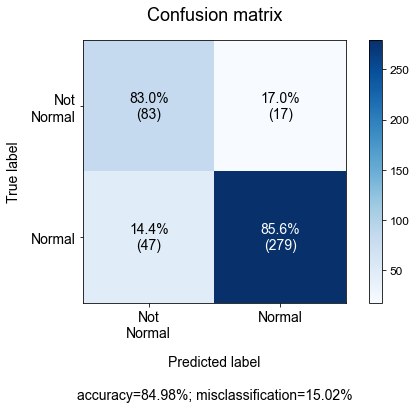

In [52]:
# Confusion Matrix
cm_pca = confusion_matrix(y_test, y_pred_pca)
plot_confusion_matrix(cm_pca, target_names=[classes_dict[i] for i in model_logreg_pca.classes_])

In [53]:
print(classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

           0       0.64      0.83      0.72       100
           1       0.94      0.86      0.90       326

    accuracy                           0.85       426
   macro avg       0.79      0.84      0.81       426
weighted avg       0.87      0.85      0.86       426



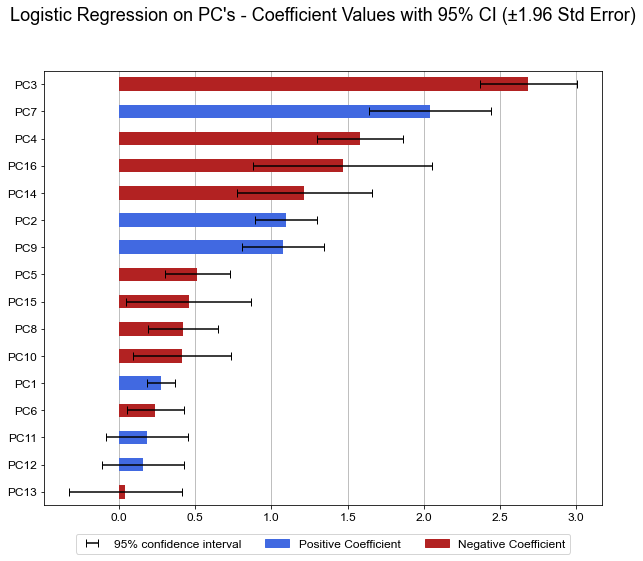

In [54]:
df_importance_components_pca = pd.DataFrame(np.transpose(model_logreg_pca.coef_), columns=['Coefficients'], index=pca_cols)
df_importance_components_pca['Standard Error'] = logit_stderror(model_logreg_pca, X_train_pca)[1:]
df_importance_components_pca = plot_importance(df_importance_components_pca, model_description="Logistic Regression on PC's")

CI for the coefficients of the original features is the square root of the sum of the squares of the radius of the CI for the coefficients of the principal components.

Sources:
- Stack Exchange: https://stats.stackexchange.com/a/224760
- Uncertainties and Error Propagation: https://www.geol.lsu.edu/jlorenzo/geophysics/uncertainties/Uncertaintiespart2.html
- Error Propagation (Propagation of Uncertainty): https://www.statisticshowto.com/statistics-basics/error-propagation/

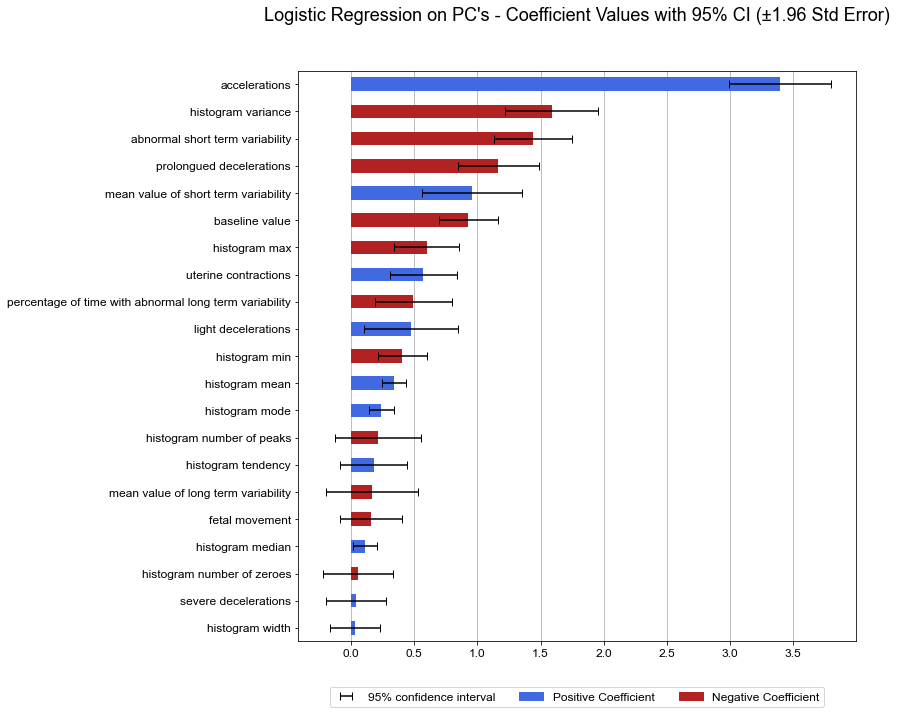

In [55]:
df_importance_pca = X_train_pca_coeffs.multiply(
                        df_importance_components_pca['Coefficients'], axis='index'
                    ).sum(axis=0).to_frame(name='Coefficients')

# Source: https://stats.stackexchange.com/questions/223924/how-to-add-up-partial-confidence-intervals-to-create-a-total-confidence-interval
df_importance_pca['Standard Error'] = np.sqrt((X_train_pca_coeffs.multiply(df_importance_components_pca['Standard Error'], axis='index')**2).sum(axis=0))

df_importance_pca = plot_importance(df_importance_pca, model_description="Logistic Regression on PC's")

In [56]:
# Check if PCA reverse tranformation was done correctly
check_pca_transform(X_test_std_allcols, y_pred_pca, df_importance_pca, model_logreg_pca.intercept_, classes_dict)

SUCCESS: PCA coefficients reverse transformation was performed correctly!


### 3.2. Logistic Regression on original dataset

In [57]:
# High-VIF columns
high_vif_cols

['histogram width',
 'histogram median',
 'histogram mean',
 'baseline value',
 'histogram mode',
 'histogram max',
 'histogram min']

In [58]:
# define columns to remove
cols_to_remove = high_vif_cols

X_train_std = X_train_std_allcols[[col for col in X_train_std_allcols.columns if col not in cols_to_remove]]
X_test_std = X_test_std_allcols[[col for col in X_test_std_allcols.columns if col not in cols_to_remove]]

In [59]:
%%time
# Hyperparameter tuning with Grid Search Cross Validation

result_cv_logreg = gridsearch_cv(X_train_std, y_train, model=LogisticRegression(), 
                                 space=space_logreg, n_splits=4, n_repeats=2, refit='f1', random_state=0)
result_cv_logreg

CPU times: user 547 ms, sys: 82.1 ms, total: 629 ms
Wall time: 2.17 s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=4, random_state=0),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02]),
                         'class_weight': ['balanced'],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             refit='f1',
             scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])

In [60]:
print_metrics_cv(result_cv_logreg)

Grid Search CV Best Model - Scoring Metrics:

ROC AUC:   0.957
Accuracy:  0.878
Precision: 0.967
Recall:    0.873
F1 score:  0.918


Best Hyperparameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}




In [61]:
# define best model
model_logreg = LogisticRegression(
    **result_cv_logreg.best_params_, random_state=0
)

In [62]:
# Fit model and make predictions
model_logreg.fit(X_train_std, y_train)
y_pred = model_logreg.predict(X_test_std)
y_pred_proba = model_logreg.predict_proba(X_test_std)
print(f'Accuracy on Training Set: {100*model_logreg.score(X_train_std, y_train):.1f}%')
print(f'Accuracy on Test Set:     {100*model_logreg.score(X_test_std, y_test):.1f}%')

Accuracy on Training Set: 88.7%
Accuracy on Test Set:     86.9%


In [63]:
print_metrics(y_test, y_pred)

Final Model - Scoring Metrics on Test Dataset:

ROC AUC:   0.876
Accuracy:  0.869
Precision: 0.962
Recall:    0.862
F1 score:  0.909


Classification Report: 

              precision    recall  f1-score   support

           0       0.66      0.89      0.76       100
           1       0.96      0.86      0.91       326

    accuracy                           0.87       426
   macro avg       0.81      0.88      0.84       426
weighted avg       0.89      0.87      0.87       426



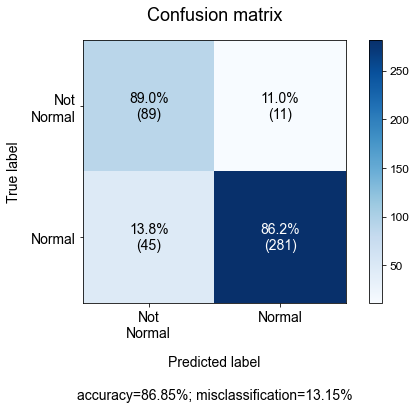

In [64]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=[classes_dict[i] for i in model_logreg.classes_])

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.89      0.76       100
           1       0.96      0.86      0.91       326

    accuracy                           0.87       426
   macro avg       0.81      0.88      0.84       426
weighted avg       0.89      0.87      0.87       426



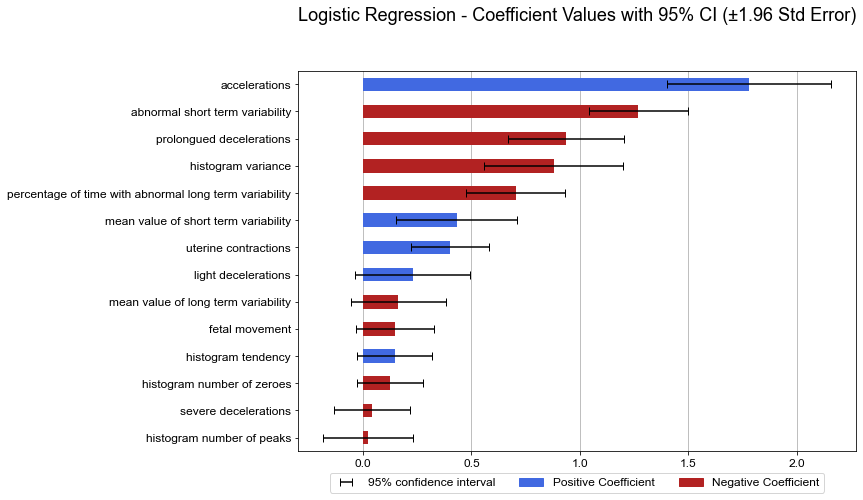

In [66]:
df_importance = pd.DataFrame(np.transpose(model_logreg.coef_), columns=['Coefficients'], index=X_train_std.columns)
df_importance['Standard Error'] = logit_stderror(model_logreg, X_train_std)[1:]
df_importance = plot_importance(df_importance, model_description="Logistic Regression")

## 4. XGBoost Classifier

In [67]:
import xgboost as xgb
from xgboost import XGBClassifier
import shap

In [68]:
y_train.value_counts()

1    1329
0     371
Name: fetal health binary, dtype: int64

In [69]:
# Calculate negative class odds (ratio of # of negative class samples to # of positive class samples) to correct for class imbalance
# neg_class_odds = (sum(negative instances) / sum(positive instances))

neg_class_odds = y_train[y_train == 0].count() / y_train[y_train == 1].count()
neg_class_odds

0.27915726109857036

XGBoost parameter explanation: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

In [70]:
space_xgb = {
    'objective': ['binary:logistic', 'binary:hinge'],
    'n_estimators': [40, 50, 60],
    'learning_rate': [0.1],
    'max_depth': [4, 5, 6],
    'min_child_weight': [2, 3, 5],
    'gamma': [0, 0.5],
    'alpha':[0, 0.3],
    'scale_pos_weight': [neg_class_odds],
    'lambda':[1, 1.25],
    ## 'subsample': [0.8, 1.0],
    ## 'colsample_bytree': [0.8, 1.0],
    'verbosity': [0], # 0 to ignore warnings
}

In [71]:
eval_metrics = {
    'logloss': 'Binary Cross-entropy Loss (aka Logistic Log-loss)',
    'error': 'Binary Classification Error Rate',
    'auc': 'ROC AUC'
}

### 4.1. XGBoost on PC's

In [72]:
%%time
# Hyperparameter tuning with Grid Search Cross Validation

result_cv_xgb_pca = gridsearch_cv(X_train_pca, y_train, model=XGBClassifier(), 
                                 space=space_xgb, n_splits=4, n_repeats=1, refit='f1', random_state=0)
result_cv_xgb_pca

CPU times: user 2.72 s, sys: 888 ms, total: 3.61 s
Wall time: 13min 39s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=4, random_state=0),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None...
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.3], 'gamma': [0, 0.5],
                         'lambda': [1, 1.25], 'learning_rate': [0.1],
                         'max_depth': [4, 5, 6], 'min_child_weight': [2, 3, 5],
                         'n_estimators': [40, 50, 60],
                         'objective': ['binary:logistic', 'binary:hinge'],
                         'scale_pos_weight': [0.27915726109857036],
                         'verbosity': [0]},
             refit='f1',
             scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])

In [73]:
print_metrics_cv(result_cv_xgb_pca)

Grid Search CV Best Model - Scoring Metrics:

ROC AUC:   0.874
Accuracy:  0.923
Precision: 0.942
Recall:    0.961
F1 score:  0.951


Best Hyperparameters: {'alpha': 0, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 60, 'objective': 'binary:hinge', 'scale_pos_weight': 0.27915726109857036, 'verbosity': 0}




In [74]:
# define best model
model_xgb_pca = XGBClassifier(
    **result_cv_xgb_pca.best_params_, random_state=0
)

In [75]:
# Fit model and make predictions
model_xgb_pca.fit(X_train_pca, y_train, eval_set=[(X_train_pca, y_train), (X_test_pca, y_test)], eval_metric=list(eval_metrics.keys()), verbose=False)
y_pred_pca = model_xgb_pca.predict(X_test_pca)
y_pred_proba_pca = model_xgb_pca.predict_proba(X_test_pca)
print(f'Accuracy on Training Set: {100*model_xgb_pca.score(X_train_pca, y_train):.1f}%')
print(f'Accuracy on Test Set:     {100*model_xgb_pca.score(X_test_pca, y_test):.1f}%')

Accuracy on Training Set: 99.1%
Accuracy on Test Set:     92.3%


In [76]:
print_metrics(y_test, y_pred_pca)

Final Model - Scoring Metrics on Test Dataset:

ROC AUC:   0.884
Accuracy:  0.923
Precision: 0.943
Recall:    0.957
F1 score:  0.950


Classification Report: 

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       100
           1       0.94      0.96      0.95       326

    accuracy                           0.92       426
   macro avg       0.90      0.88      0.89       426
weighted avg       0.92      0.92      0.92       426



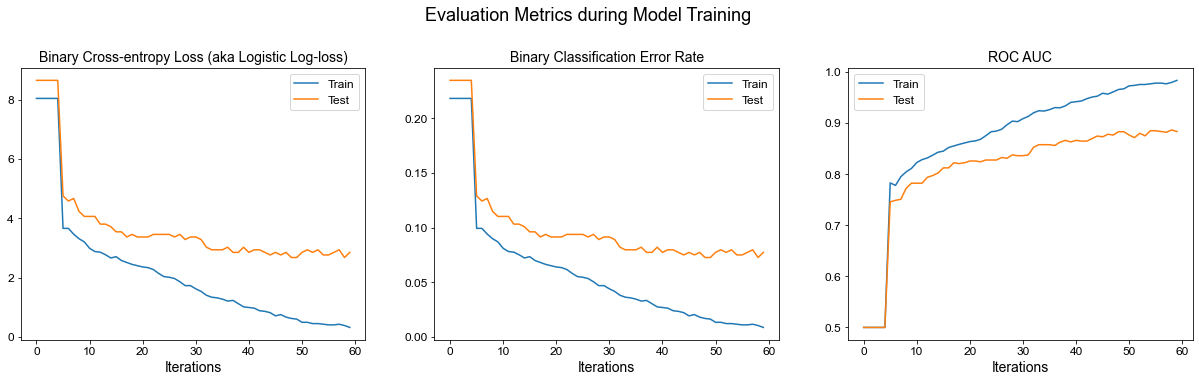

In [77]:
plot_eval_metrics_xgb(model_xgb_pca.evals_result(), eval_metrics)

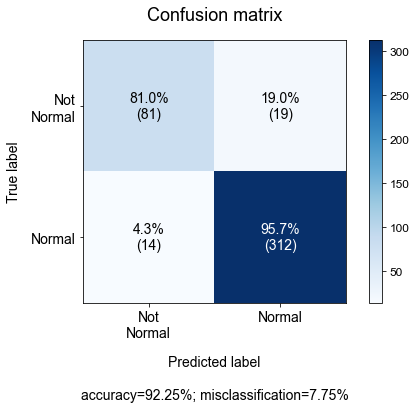

In [78]:
# Confusion Matrix
cm_pca = confusion_matrix(y_test, y_pred_pca)
plot_confusion_matrix(cm_pca, target_names=[classes_dict[i] for i in model_xgb_pca.classes_])

**SHAP Analysis**

In [79]:
explainer = shap.TreeExplainer(model_xgb_pca)
shap_values_pca = explainer.shap_values(X_test_pca)

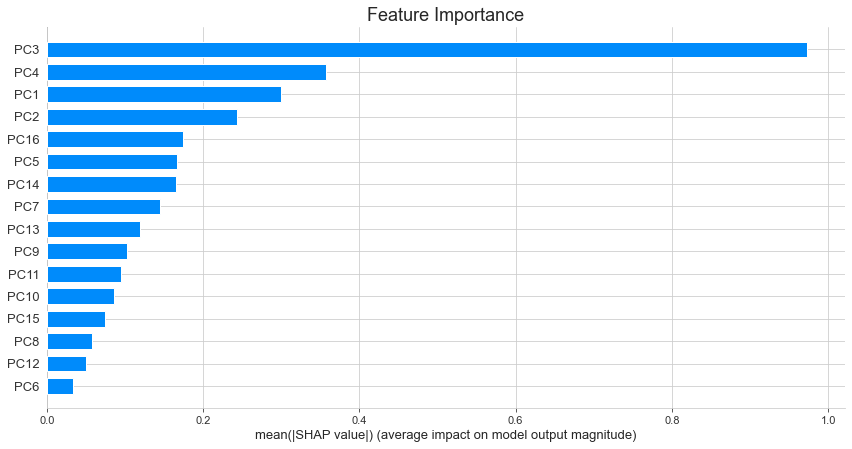

In [80]:
plot_shap_importance(shap_values_pca, X_test_pca, classes_dict, model_xgb_pca.classes_)

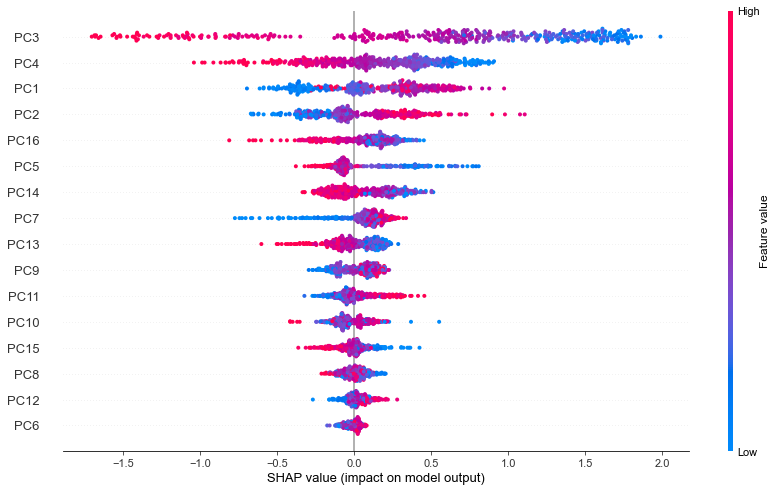

In [81]:
shap.summary_plot(np.array(shap_values_pca), X_test_pca, feature_names=pca_cols, show=True, max_display=None, plot_size=(12,7))

In [82]:
df_shap_pca = pd.DataFrame(shap_values_pca, columns=X_test_pca.columns)
df_importance_shap_pca = df_shap_pca.T.abs().mean(axis=1).to_frame(name='mean(|SHAP|)')

# df_importance_pca.sort_values('mean(|SHAP|)', ascending=False)

In [83]:
shap_values = np.dot(shap_values_pca, X_train_pca_coeffs.values)

In [84]:
df_shap = pd.DataFrame(shap_values, columns=X.columns)
df_importance_shap = df_shap.T.abs().mean(axis=1).to_frame(name='Feature Importance - derived from mean(|SHAP|)')

# df_importance_shap.sort_values('Feature Importance - derived from mean(|SHAP|)', ascending=False)

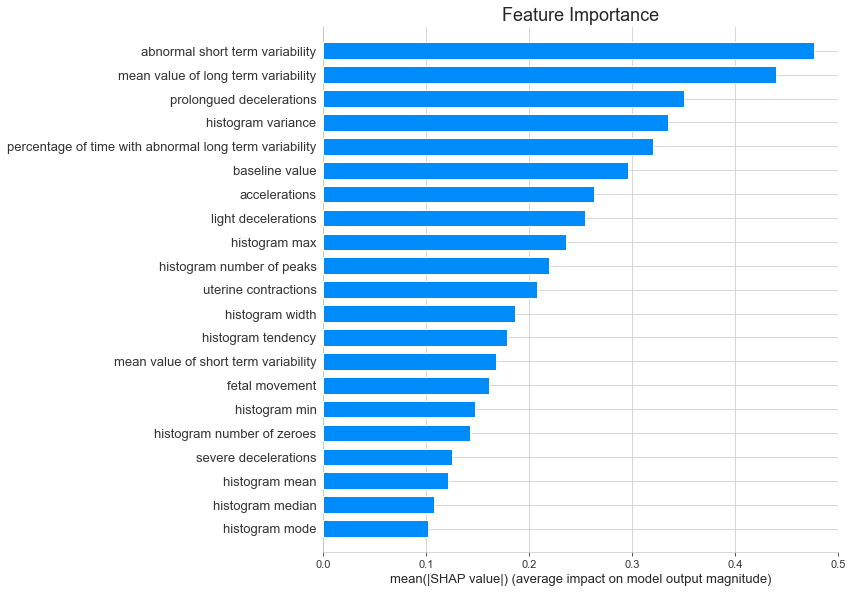

In [85]:
plot_shap_importance(shap_values, X_test_std_allcols, classes_dict, model_xgb_pca.classes_)

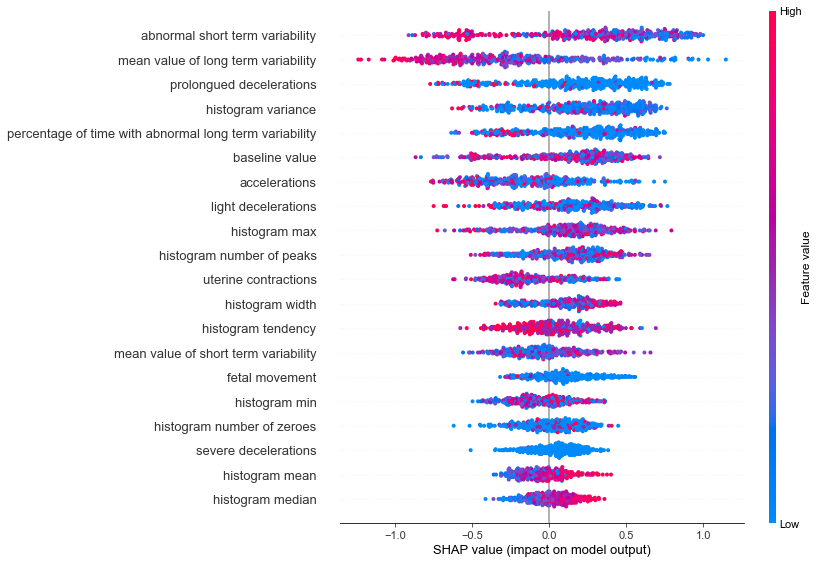

In [86]:
shap.summary_plot(np.array(shap_values), X_test_std_allcols, feature_names=X_test_std_allcols.columns, show=True, max_display=None, plot_size=(12,8))

**Feature Importance from XGBoost 'gain' metric**

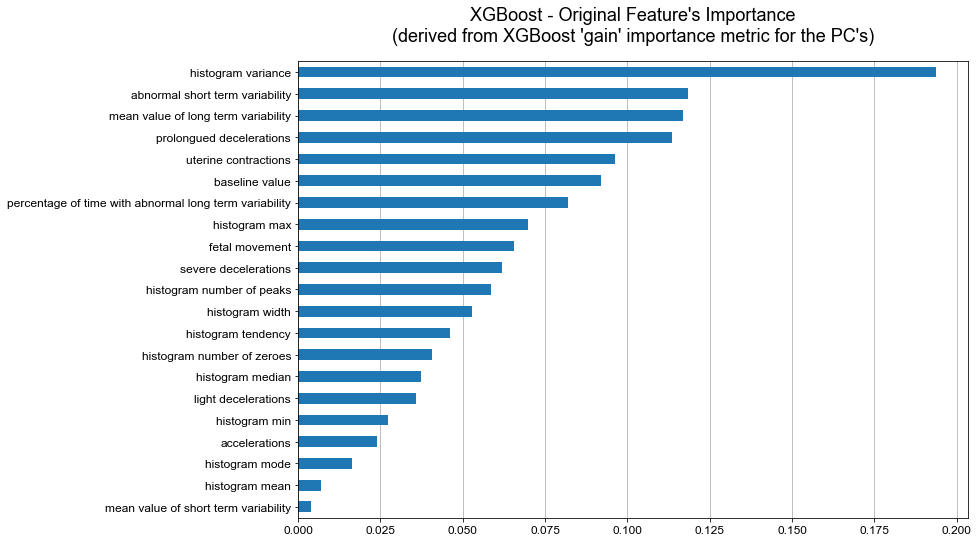

In [87]:
df_importance_gain_pca = pd.DataFrame(model_xgb_pca.feature_importances_, index=pca_cols, columns=['PC Feature Gain'])
df_importance_gain = X_train_pca_coeffs.multiply(df_importance_gain_pca['PC Feature Gain'], axis='index').sum(axis=0).abs().to_frame(name='Feature Gain')

plot_gain_metric_xgb(df_importance_gain, title="XGBoost - Original Feature's Importance\n(derived from XGBoost 'gain' importance metric for the PC's)")

### 4.2. XGBoost on original dataset

In [88]:
# High-VIF columns
high_vif_cols

['histogram width',
 'histogram median',
 'histogram mean',
 'baseline value',
 'histogram mode',
 'histogram max',
 'histogram min']

In [89]:
# define columns to remove
cols_to_remove = high_vif_cols

X_train_std = X_train_std_allcols[[col for col in X_train_std_allcols.columns if col not in cols_to_remove]]
X_test_std = X_test_std_allcols[[col for col in X_test_std_allcols.columns if col not in cols_to_remove]]

In [90]:
%%time
# Hyperparameter tuning with Grid Search Cross Validation

result_cv_xgb = gridsearch_cv(X_train_std, y_train, model=XGBClassifier(), 
                                 space=space_xgb, n_splits=4, n_repeats=1, refit='f1', random_state=0)
result_cv_xgb

CPU times: user 1.89 s, sys: 627 ms, total: 2.52 s
Wall time: 14min 48s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=4, random_state=0),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None...
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.3], 'gamma': [0, 0.5],
                         'lambda': [1, 1.25], 'learning_rate': [0.1],
                         'max_depth': [4, 5, 6], 'min_child_weight': [2, 3, 5],
                         'n_estimators': [40, 50, 60],
                         'objective': ['binary:logistic', 'binary:hinge'],
                         'scale_pos_weight': [0.27915726109857036],
                         'verbosity': [0]},
             refit='f1',
             scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])

In [91]:
print_metrics_cv(result_cv_xgb)

Grid Search CV Best Model - Scoring Metrics:

ROC AUC:   0.891
Accuracy:  0.944
Precision: 0.946
Recall:    0.985
F1 score:  0.965


Best Hyperparameters: {'alpha': 0.3, 'gamma': 0.5, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 50, 'objective': 'binary:hinge', 'scale_pos_weight': 0.27915726109857036, 'verbosity': 0}




In [92]:
# define best model
model_xgb = XGBClassifier(
    **result_cv_xgb.best_params_, random_state=0
)

In [93]:
# Fit model and make predictions
model_xgb.fit(X_train_std, y_train, eval_set=[(X_train_std, y_train), (X_test_std, y_test)], eval_metric=list(eval_metrics.keys()), verbose=False)
y_pred = model_xgb.predict(X_test_std)
y_pred_proba = model_xgb.predict_proba(X_test_std)
print(f'Accuracy on Training Set: {100*model_xgb.score(X_train_std, y_train):.1f}%')
print(f'Accuracy on Test Set:     {100*model_xgb.score(X_test_std, y_test):.1f}%')

Accuracy on Training Set: 96.8%
Accuracy on Test Set:     92.5%


In [94]:
print_metrics(y_test, y_pred)

Final Model - Scoring Metrics on Test Dataset:

ROC AUC:   0.854
Accuracy:  0.925
Precision: 0.920
Recall:    0.988
F1 score:  0.953


Classification Report: 

              precision    recall  f1-score   support

           0       0.95      0.72      0.82       100
           1       0.92      0.99      0.95       326

    accuracy                           0.92       426
   macro avg       0.93      0.85      0.89       426
weighted avg       0.93      0.92      0.92       426



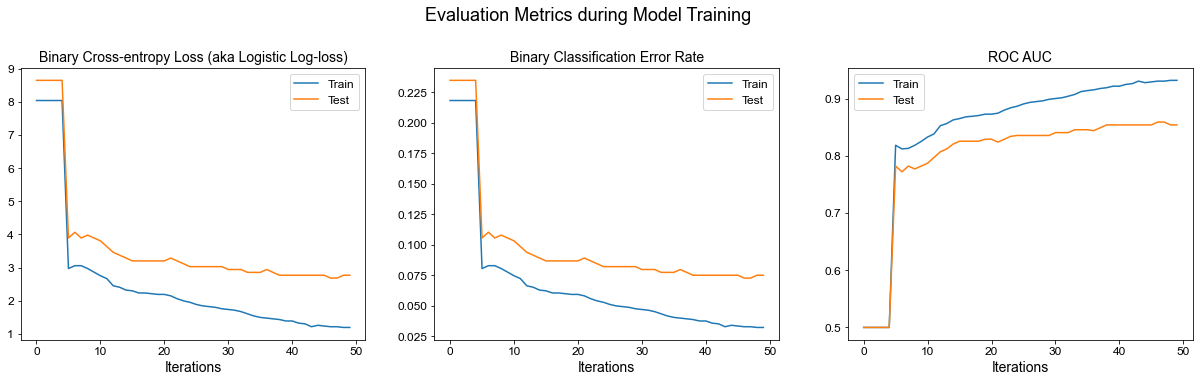

In [95]:
plot_eval_metrics_xgb(model_xgb.evals_result(), eval_metrics)

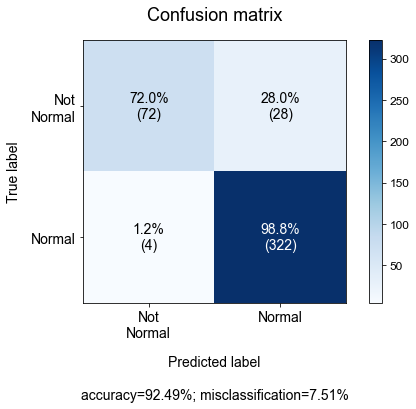

In [96]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=[classes_dict[i] for i in model_xgb.classes_])

**SHAP Analysis**

In [97]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_std)

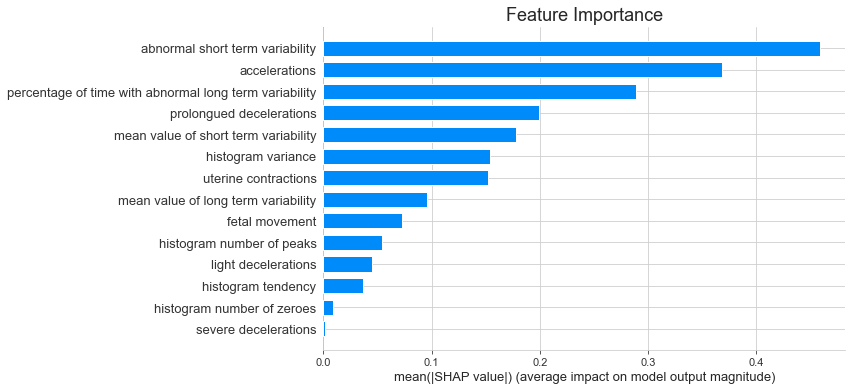

In [98]:
plot_shap_importance(shap_values, X_test_std, classes_dict, model_xgb.classes_)

In [99]:
df_shap = pd.DataFrame(shap_values, columns=X_test_std.columns)
df_importance_shap = df_shap.T.abs().mean(axis=1).to_frame(name='mean(|SHAP|)')

# df_importance_shap.sort_values('mean(|SHAP|)', ascending=False)

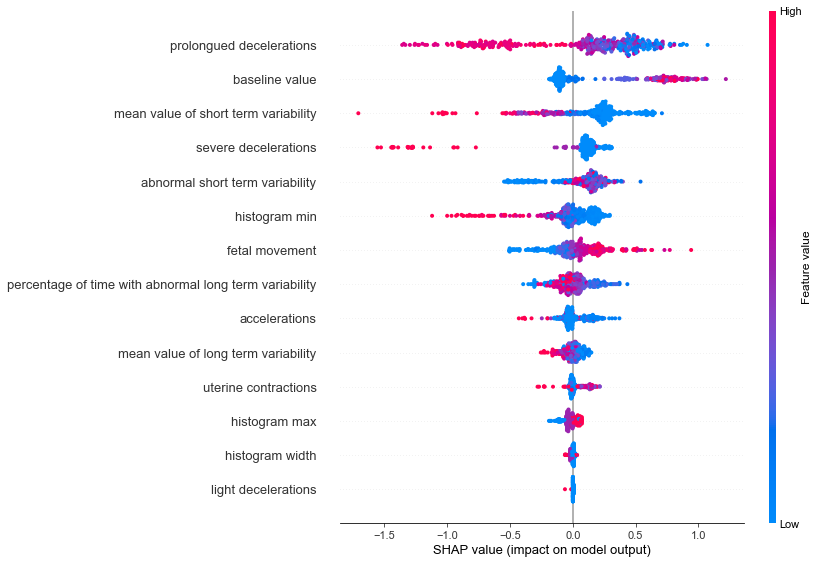

In [100]:
shap.summary_plot(np.array(shap_values), X_test_std, feature_names=X_test_std_allcols.columns, show=True, max_display=None, plot_size=(12,8))

**Feature Importance from XGBoost 'gain' metric**

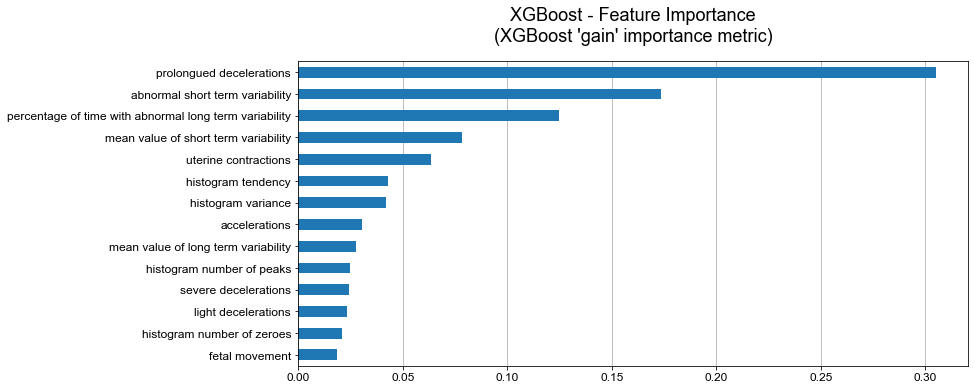

In [101]:
df_importance_gain = pd.DataFrame(model_xgb.feature_importances_, index=X_test_std.columns, columns=['Feature Gain'])

plot_gain_metric_xgb(df_importance_gain, title="XGBoost - Feature Importance\n(XGBoost 'gain' importance metric)")